In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['MODELSCOPE_CACHE']="/data0/modelscope/qwen2.5"

In [2]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

In [3]:
import sys
sys.path.insert(0, '/home/hushengchun/python_library/TransformerLens/')

import transformer_lens
from argparse import ArgumentParser
from functools import partial 
from pathlib import Path

import pandas as pd
import numpy as np
import torch
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt
from tqdm import tqdm

from eap.graph import Graph
from eap.attribute import attribute, _plot_attn, tokenize_plus
from eap.evaluate import evaluate_graph, evaluate_baseline

from dataset import EAPDataset
from metrics import get_metric
from transformers import BitsAndBytesConfig
from modelscope import AutoModelForCausalLM, AutoTokenizer

In [4]:
bnbconfig = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type='nf4'
)

In [5]:
# model_name = "qwen/Qwen2.5-32B-Instruct-GPTQ-INT4"
# model_name = "qwen/Qwen2.5-32B-Instruct"
model_name = "Qwen/Qwen2.5-7B-Instruct"
model_base = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    cache_dir="/data0/modelscope/qwen2.5",
    local_files_only=True, low_cpu_mem_usage=True,
    quantization_config=bnbconfig
)

2025-03-17 03:56:29,624 - modelscope - WARNING - Using branch: master as version is unstable, use with caution
2025-03-17 03:56:29,978 - modelscope - INFO - Target directory already exists, skipping creation.


In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/config.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/config.json


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

2025-03-17 03:56:37,246 - modelscope - WARNING - Using branch: master as version is unstable, use with caution
2025-03-17 03:56:37,534 - modelscope - INFO - Target directory already exists, skipping creation.


In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/tokenizer_config.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/tokenizer_config.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/vocab.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/merges.txt
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/tokenizer.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# output test
prompt = "Bob and Tom go to the market, Bob give an apple to"
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model_base.device)
generated_ids = model_base.generate(
    **model_inputs,
    max_new_tokens=512,
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]
response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
response

ValueError: The following `model_kwargs` are not used by the model: ['temperatrue'] (note: typos in the generate arguments will also show up in this list)

In [8]:
model = HookedTransformer.from_pretrained("Qwen/Qwen2.5-7B-Instruct",center_writing_weights=False,
    center_unembed=False,
    fold_ln=False,
    fold_value_biases=False,
    device='cuda',
    hf_model=model_base,
    tokenizer=tokenizer,
    hf_model_4bit=True,
    dtype="float16",
)

In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/tokenizer_config.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/tokenizer_config.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/vocab.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/merges.txt
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct /data0/modelscope/qwen2.5/models/Qwen/Qwen2___5-7B-Instruct/tokenizer.json
In cached_file: path_or_repo_id, resolved_file = /data0/modelscope/qwen2.5

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model Qwen/Qwen2.5-7B-Instruct into HookedTransformer


In [17]:
# output test
prompt = "Kinds of things include instrument, animal, fruit and clothes.\nPremise: < Jason has pig. Mark has shirt. Kenneth has kiwi. >. Answer with Yes or No. Can it be inferred from the premise that Kenneth owns a kind of fruit? Answer: "
output = model.generate(prompt, 
                        max_new_tokens=2, 
                        temperature=0)
output.removeprefix(prompt)

  0%|          | 0/2 [00:00<?, ?it/s]

' Yes.'

In [18]:
task = 'ioi'

In [19]:
model.cfg.use_split_qkv_input = False
model.cfg.use_attn_result = True
model.cfg.use_hook_mlp_in = True

In [20]:
task_metric_name = 'prob_diff'
ds = EAPDataset(task, model_name)
batch_size = 10
dataloader = ds.to_dataloader(batch_size)
task_metric = get_metric(task_metric_name, task, model=model)

In [21]:
model_name_noslash = model_name.split('/')[-1]

import time
T1 = time.time()
g = Graph.from_model(model)
T2 = time.time()

print('运行时间：%s s' %(T2 - T1))

运行时间：5.549204349517822 s


In [22]:
T1 = time.time()
attribute(model, g, dataloader, partial(task_metric, mean=True, loss=True), method='EAP-IG', ig_steps=5)
T2 = time.time()

print('运行时间：%s s' %(T2 - T1))

100%|██████████| 935747/935747 [00:01<00:00, 797889.52it/s]

运行时间：256.8274052143097 s


In [40]:
g.apply_greedy(5100, absolute=False)
g.prune_dead_nodes()
gs = g.to_graphviz()
gs.draw(f'qwen2_5-7b_4bit-ioi-split_qkv_false.png', prog='dot')

In [32]:
dataloader = tqdm(dataloader)
dataloader = list(dataloader)

100%|██████████| 100/100 [00:00<00:00, 928.05it/s]


In [ ]:
layer, head = [(27, 0), (27, 13)][1]

In [32]:
layer, head = [(26, 27)][0]

In [34]:
layer, head = [(22, 25)][0]

In [36]:
layer, head = [(15, 26)][0]

In [49]:
layer, head = [(18, 9), (18, 26)][0]

In [57]:
layer, head = [(10, 6)][0]

In [84]:
layer, head = [(2, 10)][0]

In [33]:
layer, head = [(27, 26)][0]

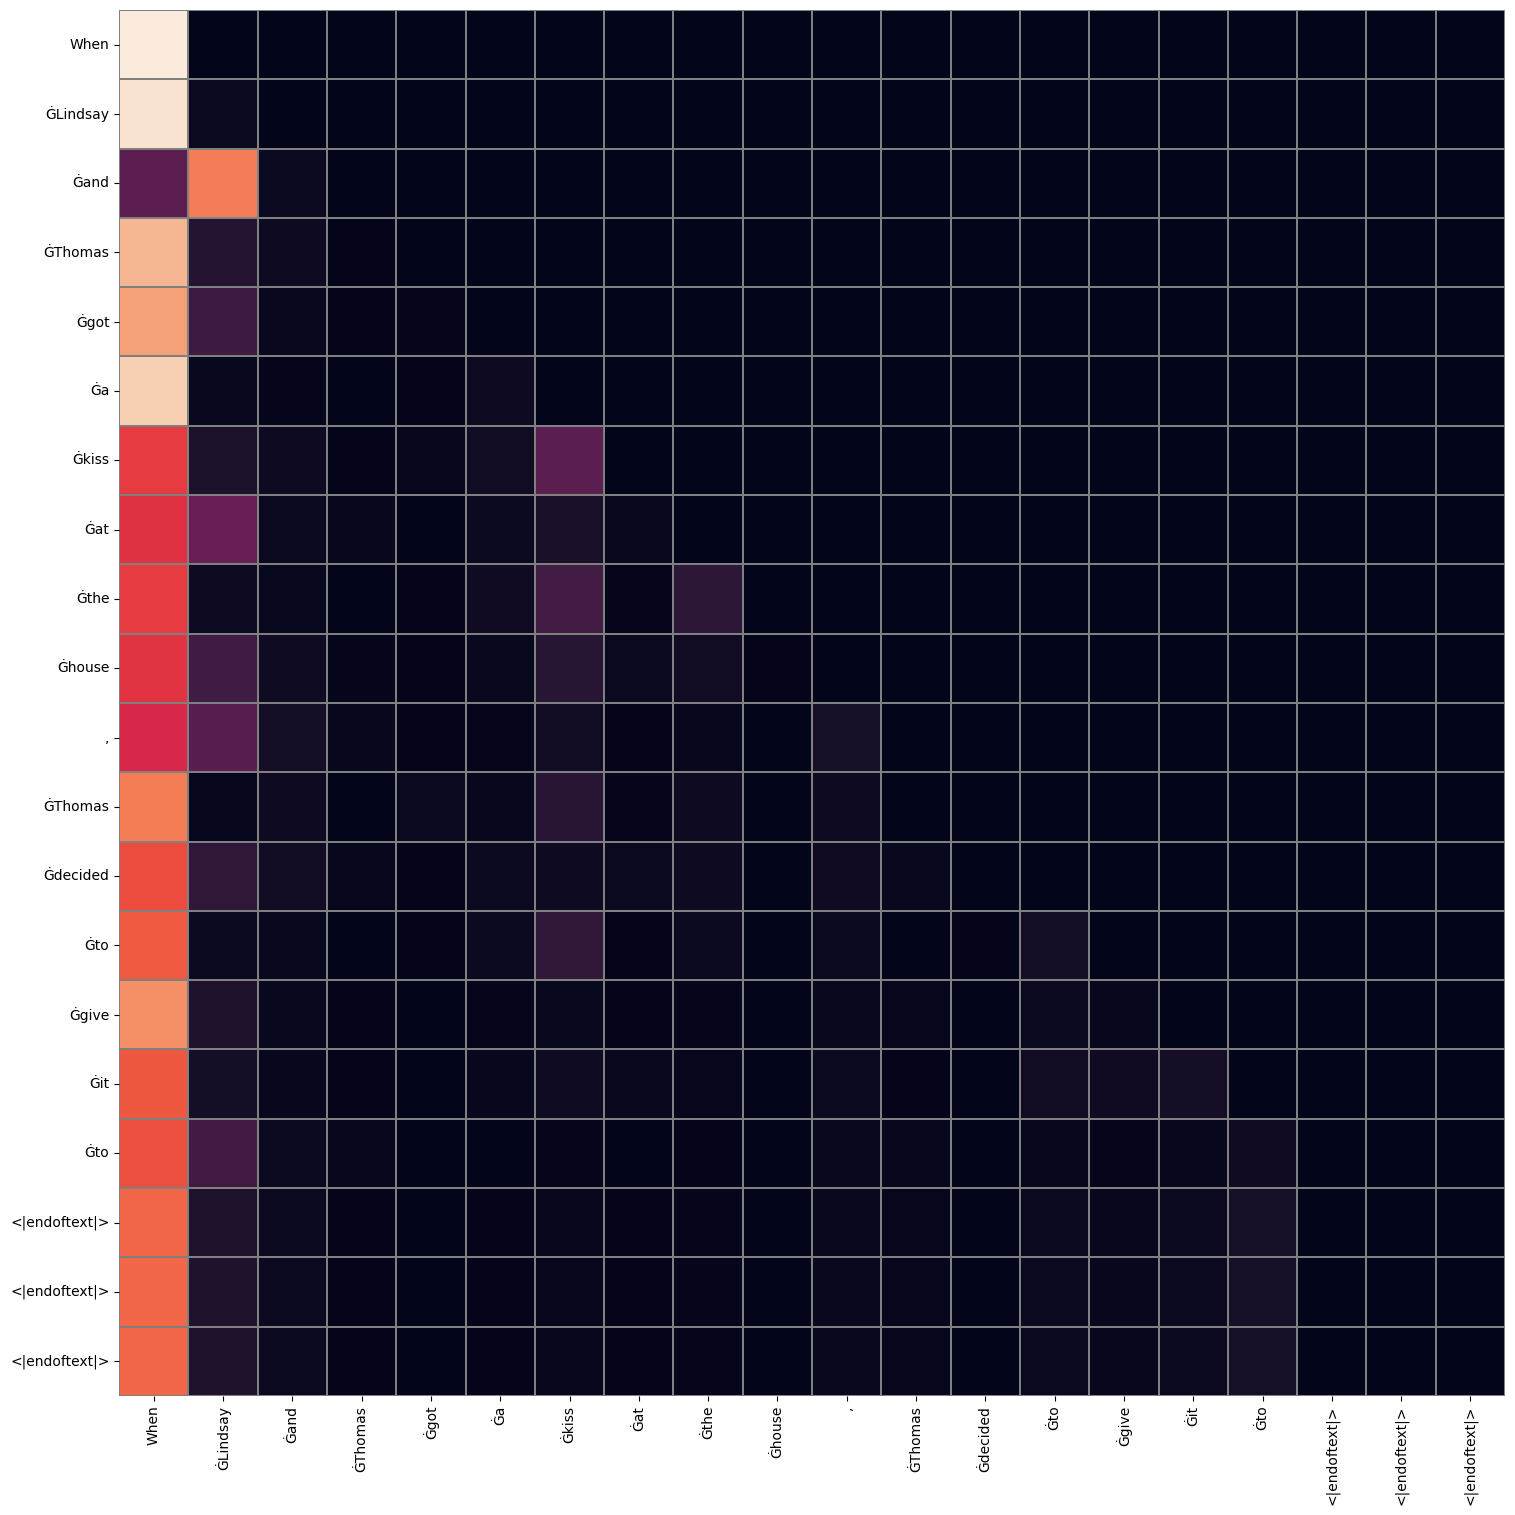

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [9.7373e-01, 2.6275e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4104e-01, 7.3039e-01, 2.8570e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.6227e-01, 9.7259e-02, 3.4960e-02, 5.5099e-03, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       

In [37]:
from eap.attribute import tokenize_plus
for clean, corrupt, label in dataloader[1:2]:
    # tokens_ids = model.to_tokens(clean, prepend_bos=True, padding_side='right')
    token_ids, attention_mask, input_lengths, n_pos = tokenize_plus(model, clean)
    clean_logits, cache = model.run_with_cache(token_ids, attention_mask = attention_mask)
    tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
    attn = cache[f'blocks.{layer}.attn.hook_pattern'][0][head]
    _plot_attn(attn, tokens, figsize=(18, 18))
    print(attn, attn.size())

In [42]:
g.edges

{'input->a0.h0<q>': Edge(input->a0.h0<q>, score: -1.341104507446289e-05, in_graph: False),
 'input->a0.h0<k>': Edge(input->a0.h0<k>, score: 8.344650268554688e-07, in_graph: False),
 'input->a0.h0<v>': Edge(input->a0.h0<v>, score: -1.3589859008789062e-05, in_graph: False),
 'input->a0.h1<q>': Edge(input->a0.h1<q>, score: 3.159046173095703e-06, in_graph: False),
 'input->a0.h1<k>': Edge(input->a0.h1<k>, score: -1.4901161193847656e-06, in_graph: False),
 'input->a0.h1<v>': Edge(input->a0.h1<v>, score: 3.4570693969726562e-06, in_graph: False),
 'input->a0.h2<q>': Edge(input->a0.h2<q>, score: 4.172325134277344e-07, in_graph: False),
 'input->a0.h2<k>': Edge(input->a0.h2<k>, score: -5.841255187988281e-06, in_graph: False),
 'input->a0.h2<v>': Edge(input->a0.h2<v>, score: -4.589557647705078e-06, in_graph: False),
 'input->a0.h3<q>': Edge(input->a0.h3<q>, score: 7.808208465576172e-06, in_graph: False),
 'input->a0.h3<k>': Edge(input->a0.h3<k>, score: -4.470348358154297e-06, in_graph: False),
 